Enter the coordinate limit (e.g., 200):  200
Enter the number of computers (e.g., 10):  10
Enter the number of nodes (e.g., 500):  200


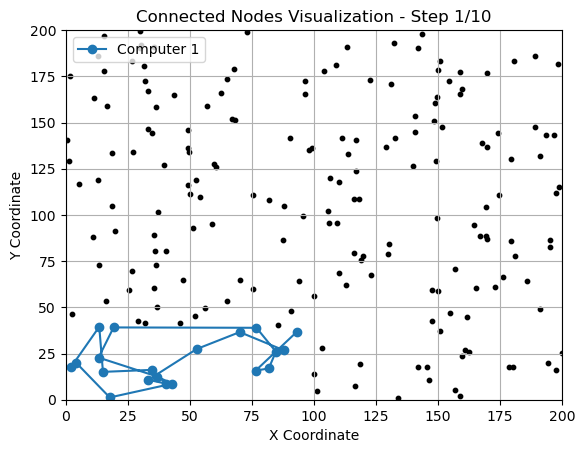

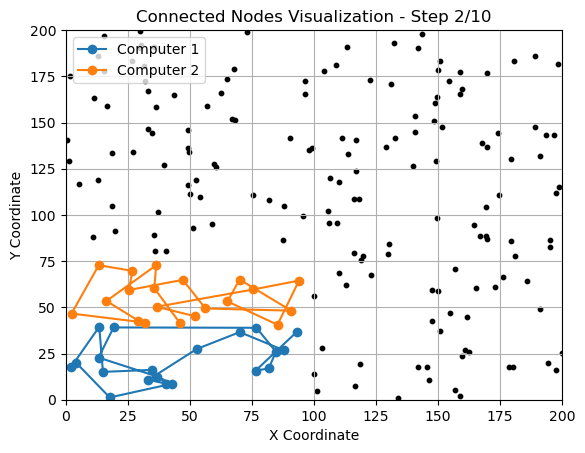

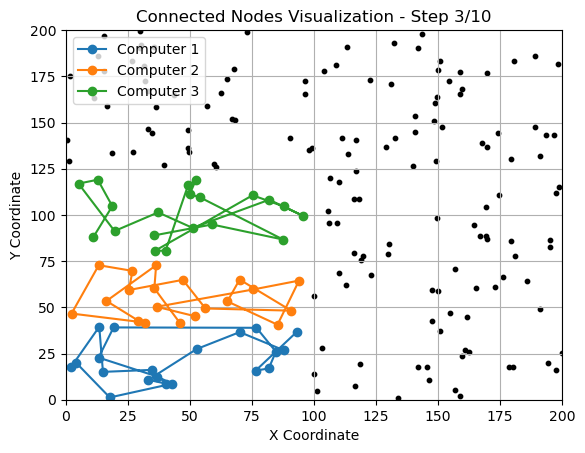

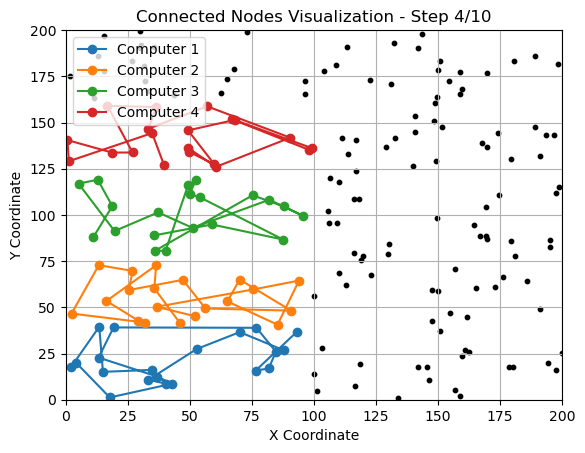

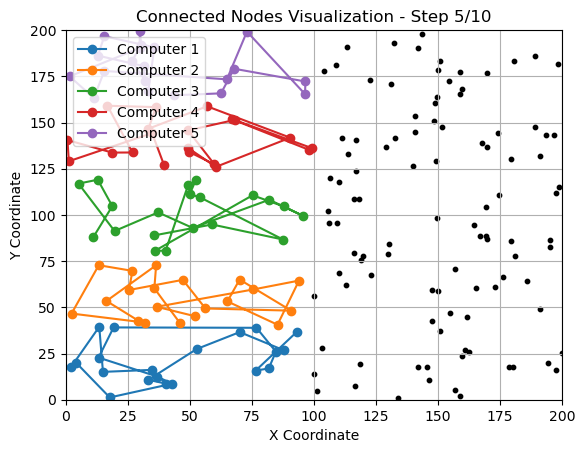

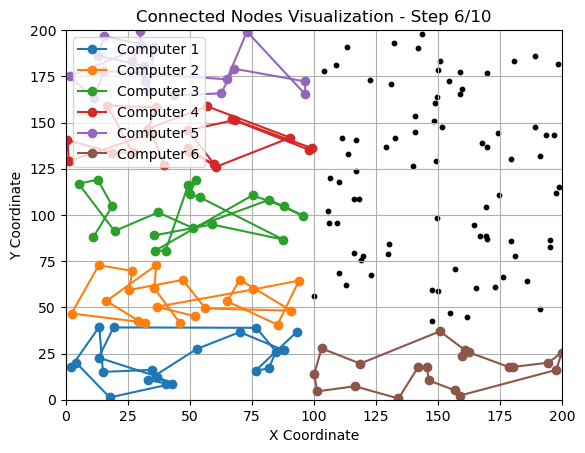

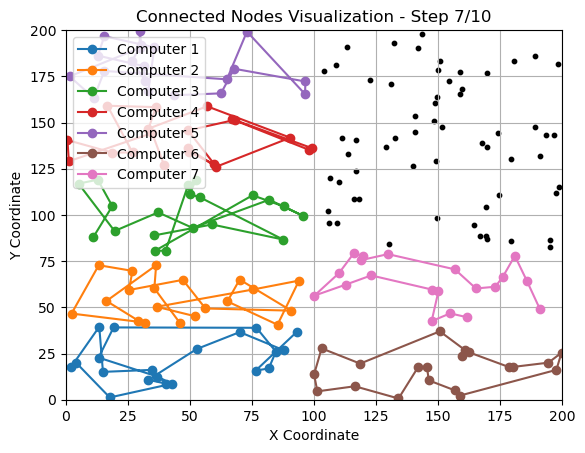

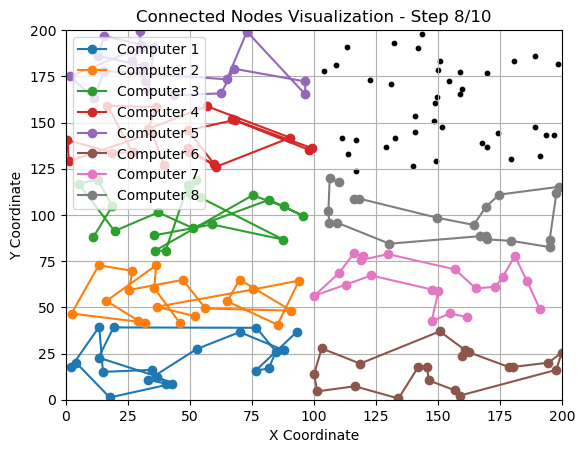

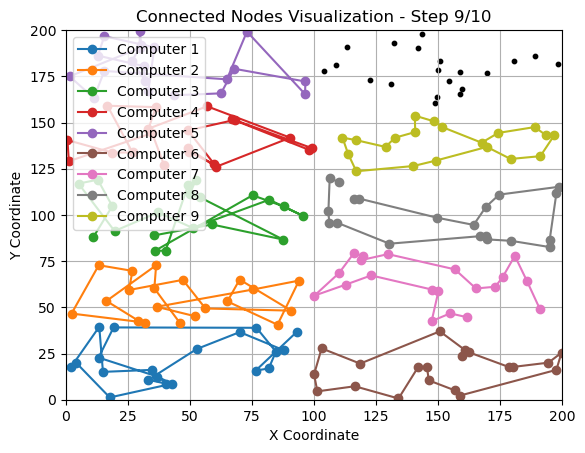

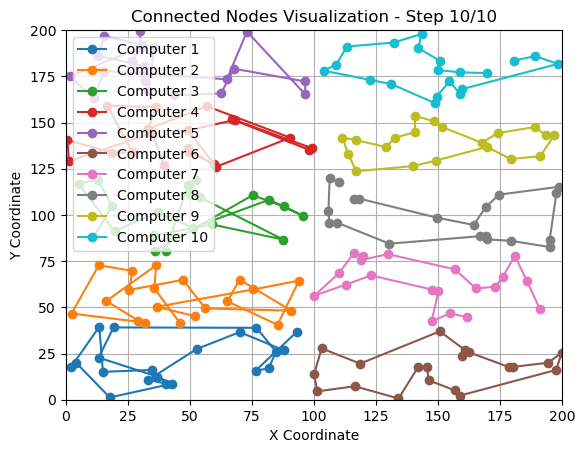

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import dist
import math
from python_tsp.heuristics import solve_tsp_simulated_annealing
import multiprocessing

# Get user inputs for node generation parameters
coordinate = int(input("Enter the coordinate limit (e.g., 200): "))  # Limit for generating coordinates
computers = int(input("Enter the number of computers (e.g., 10): "))  # Number of computers (clients)
nodes = int(input("Enter the number of nodes (e.g., 500): "))  # Total number of nodes to generate

# Function to generate random nodes within the coordinate limits
def generate_nodes():
    full_coordinates = np.empty((0, 2), float)  # Initialize an empty array to hold node coordinates
    # Determine x and y sections based on the coordinate limit and number of computers
    x_section_arr = np.linspace(0, coordinate, 3)  # Divide the coordinate range into 2 sections for x-axis
    y_section_arr = np.linspace(0, coordinate, num=int(3 + math.ceil((computers - 4) / 2)))  # More sections for y-axis

    # Check if the number of computers is even or odd to distribute nodes accordingly
    if computers % 2 == 0:
        for x_section in range(len(x_section_arr) - 1):  # Loop over x sections
            # Handle case for exactly two computers
            if computers == 2:
                # Randomly generate nodes in the entire y-axis
                x_nodes_coordintes = np.random.uniform(int(x_section_arr[x_section]),
                                                        int(x_section_arr[x_section + 1]),
                                                        size=(int(nodes / computers), 1))
                y_nodes_coordintes = np.random.uniform(0, coordinate, size=(int(nodes / computers), 1))
                col = np.column_stack((x_nodes_coordintes, y_nodes_coordintes))  # Combine x and y coordinates
                full_coordinates = np.append(full_coordinates, col, axis=0)  # Append to the full coordinates
            else:
                for y_section in range(len(y_section_arr) - 1):  # Loop over y sections
                    # Randomly generate nodes in both x and y sections
                    x_nodes_coordintes = np.random.uniform(int(x_section_arr[x_section]),
                                                            int(x_section_arr[x_section + 1]),
                                                            size=(int(nodes / computers), 1))
                    y_nodes_coordintes = np.random.uniform(int(y_section_arr[y_section]),
                                                            int(y_section_arr[y_section + 1]),
                                                            size=(int(nodes / computers), 1))
                    col = np.column_stack((x_nodes_coordintes, y_nodes_coordintes))  # Combine coordinates
                    full_coordinates = np.append(full_coordinates, col, axis=0)  # Append to full coordinates
    else:
        # Similar process for an odd number of computers
        for x_section in range(len(x_section_arr) - 1):  # Loop for x sections
            for y_section in range(len(y_section_arr) - 2):  # Loop for y sections
                x_nodes_coordintes = np.random.uniform(int(x_section_arr[x_section]),
                                                        int(x_section_arr[x_section + 1]),
                                                        size=(int(nodes / computers), 1))
                y_nodes_coordintes = np.random.uniform(int(y_section_arr[y_section]),
                                                        int(y_section_arr[y_section + 1]),
                                                        size=(int(nodes / computers), 1))
                col = np.column_stack((x_nodes_coordintes, y_nodes_coordintes))  # Combine coordinates
                full_coordinates = np.append(full_coordinates, col, axis=0)  # Append to full coordinates
        
        # Ensure that the last portion of nodes is generated to fill up remaining nodes
        x_nodes_coordintes = np.random.uniform(0, coordinate, size=(int(nodes / computers), 1))
        y_nodes_coordintes = np.random.uniform(int(y_section_arr[-2]), int(y_section_arr[-1]),
                                                  size=(int(nodes / computers), 1))
        col = np.column_stack((x_nodes_coordintes, y_nodes_coordintes))  # Combine last segment
        full_coordinates = np.append(full_coordinates, col, axis=0)  # Append to full coordinates

    return full_coordinates  # Return the generated node coordinates

# Function to calculate the pairwise distance between nodes
def calcute_distance(arr):
    distances = np.empty((0, len(arr)), float)  # Initialize a distance matrix
    for row in range(len(arr)):  # Loop through each node
        temp_dist = np.empty((0, len(arr)), float)  # Temporary storage for distances from this node
        for col in range(len(arr)):  # Loop through nodes to calculate distance from the current node to others
            point_1 = arr[row][0], arr[row][1]  # Current node coordinates
            point_2 = arr[col][0], arr[col][1]  # Other node coordinates
            # Calculate the distance and append to the temporary distance array
            temp_dist = np.insert(temp_dist, col, dist(point_1, point_2))
        distances = np.r_[distances, [temp_dist]]  # Append the row of distances to the distance matrix
    return distances  # Return the completed distance matrix

# Function to plot the paths taken by connected nodes
def plot_path(step_connections, all_coordinates, step, total_steps):
    plt.figure()  # Create a new figure for the plot
    for i, connections in enumerate(step_connections):  # Loop through each computer's connections
        x_temp = [coord[0] for coord in connections]  # Extract x coordinates
        y_temp = [coord[1] for coord in connections]  # Extract y coordinates
        plt.plot(x_temp, y_temp, marker='o', label=f'Computer {i+1}')  # Plot the path for each computer

    plt.scatter(all_coordinates[:, 0], all_coordinates[:, 1], color='black', s=10)  # Scatter plot of all nodes
    plt.title(f'Connected Nodes Visualization - Step {step}/{total_steps}')  # Title showing current step
    plt.xlabel('X Coordinate')  # X-axis label
    plt.ylabel('Y Coordinate')  # Y-axis label
    plt.legend(loc='upper left')  # Legend positioning
    plt.xlim(0, coordinate)  # Limit for x-axis
    plt.ylim(0, coordinate)  # Limit for y-axis
    plt.grid(True)  # Show grid on the plot
    plt.show()  # Display the plot

# Main starting point of the script
if __name__ == '__main__':
    all_coordinates = generate_nodes()  # Generate all node coordinates
    full_coordinates = np.array_split(all_coordinates, computers)  # Split coordinates among the computers
    connected_nodes = []  # Initialize list to store each computer's connected nodes

    for i in range(computers):  # Loop for each computer to process its nodes
        temp_arr = full_coordinates[i]  # Extract coordinates for the current computer
        if i < math.floor(computers / 2):  # If the computer index is in the first half
            # Get the coordinates of the corresponding 'future' computer index
            temp_future_arr = full_coordinates[i + int(math.floor(computers / 2))]
            distance_betwenn_two_phases = calcute_distance(temp_arr)  # Calculate distance matrix for this computer
            distance_future = calcute_distance(temp_future_arr)  # Calculate distance matrix for the future computer
            # Combine both distance matrices into one
            distance_matrix = distance_betwenn_two_phases + distance_future

            # Get the best path permutation using simulated annealing
            permutation, _ = solve_tsp_simulated_annealing(distance_matrix)
            
            # Append the connected nodes for this computer based on the permutation
            connected_nodes.append(temp_arr[permutation])
            
            # Plot and visualize the path after processing this node
            plot_path(connected_nodes, all_coordinates, step=i+1, total_steps=computers)

        else:  # For the remaining computers
            # Calculate the distance matrix for the current computer
            distance_matrix = calcute_distance(temp_arr)
            # Obtain the best path permutation
            permutation, _ = solve_tsp_simulated_annealing(distance_matrix)
            # Append the connected nodes for the current computer
            connected_nodes.append(temp_arr[permutation])
            
            # Plot and visualize the path
            plot_path(connected_nodes, all_coordinates, step=i+1, total_steps=computers)

    #print("Final connected nodes:")  # Print the final connected nodes for each computer
    #for i, conn in enumerate(connected_nodes):
        #print(f"Computer {i+1} connections:\n{conn}")  # Output the connections for each computer